# Analysing CDS via SG with BN over image and language models

In this Notebook we show the results while using Batch Normalization over the image and language models and setting the size of the LSTM hidden state to 200. We also show the update rates, ranges and variances of the image and language domains during the training phase. Note that the update rates in the logs directory are scaled by 100)

In [1]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
sys.path.append('../models/')
import retriever
from stats import stats
from tabulate import tabulate
from runCDN import RunModel as Model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
trainset_file = '../data/training/train_data.bin'
testset_file = '../data/training/test_data.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/CDS/'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spatial features]. Note that different entries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the true bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])

testset = np.load(open(testset_file, 'rb'))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

Number of words: 8242


## Txt BN
We start by adding a BN (Batch Normalization) layer only over the languge model (last RNN output). The results show that the model have a poor regularization ability.

In [2]:
params_dir = params_dir_tmp+'txtBN_200'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    bnorm=True,
    Urnn_norm=True, 
    Uatt_norm=False,
    params_dir=params_dir
        )


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:1.000
Test accuracy:0.715
Train P@1:1.000
Test P@1:0.804
Train loss loss:0.002
Test loss loss:2.094


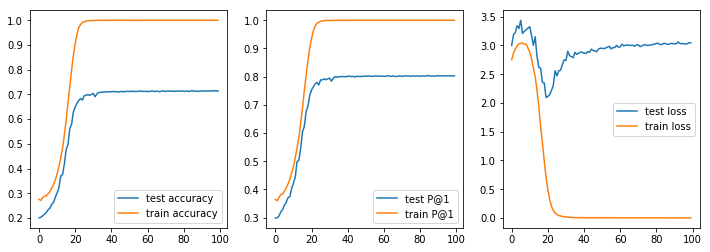

---------------------------------------------------------------------------------------------------- 



In [55]:
f = stats([tst], [trn], epochs=100, params=[200])

<p>The follwing three graphs show the standard deviations, feauture ranges and update rates of the image and language models outputs.</p> 
    
<p>Adding a BN layer over the language model increases its features range and STD significantly (see the next model results for the language statistics without a BN layer over the language model). As a results the two models update rates become closer to each other, however, since the image model is an order of magnitude higher than the language model, the relatively similar update rates causes the image model to overfit the language outputs. Indeed, we can see that once the ratio between the models update rates becomes too small, the model performances decreases</p>

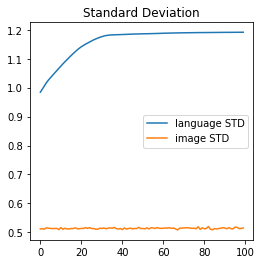

In [13]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

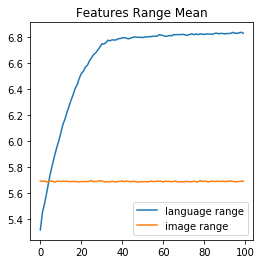

In [16]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

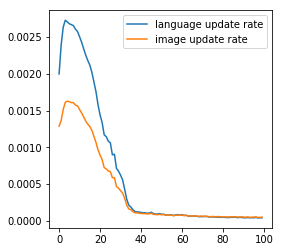

In [62]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
#     P.set_title(title)
    P.plot()
plt.show()

## Img BN

Next we add a BN layer only over the image model. Again, we see that the model overfits but now the training behavior becomes even more unstable and the test set loss increases even when the P@1 increases.

In [3]:
params_dir = params_dir_tmp+'imgBN_200'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    bnorm=True,
    Urnn_norm=False, 
    Uatt_norm=True, 
    params_dir=params_dir
        )


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100)

print('\n'+'*'*100)
print('*'*100)

Train accuracy:0.990
Test accuracy:0.615
Train P@1:0.993
Test P@1:0.727
Train loss loss:0.119
Test loss loss:2.066


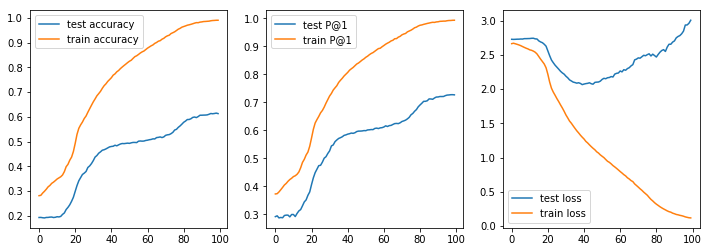

---------------------------------------------------------------------------------------------------- 



In [14]:
f = stats([tst], [trn], epochs=100, params=[200])

<p>To understand the source of this instability note that using a BN layer over the image model increases the image features range and STD which leads to an even bigger difference between the models statistics, as we can see at the graphs below. This causes a huge difference between the image and language update rates s.t the language model learns to overfit a relatively constant image embeddings.</p>

<p>Note that adding a BN layer only over the image model results in a much curvier error surface in which a higher update rate might be a good solution. We can see that as the models update rates are relatively high even when the loss is very low.</p>

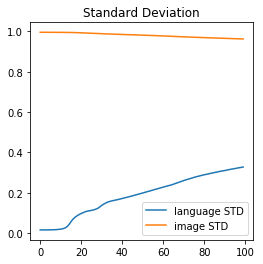

In [49]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

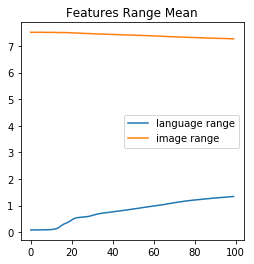

In [18]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

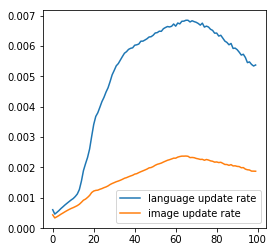

In [66]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
#     P.set_title(title)
    P.plot()
plt.show()

## BN

Finally we add a BN layers over both the image and language models. We can see that the results are similar to what we've got with a BN layer only over the language model.

In [4]:
tf.reset_defaulrd=0
params_dir = params_dir_tmp+'BN_200'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    bnorm=True,
    Urnn_norm=True, 
    Uatt_norm=True,
    params_dir=params_dir
        )


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:1.000
Test accuracy:0.730
Train P@1:1.000
Test P@1:0.819
Train loss loss:0.004
Test loss loss:2.285


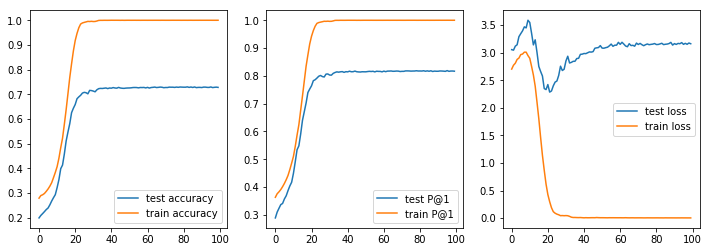

---------------------------------------------------------------------------------------------------- 



In [59]:
f = stats([tst], [trn], epochs=100, params=[200])

<p>As we saw when we used a BN layer only over the image model, the graphs below show that with BN layers over both models, the models statistics become similar and as a results their update rates become similar, due to the image model higher capacity, this leads it to overfit the language model output.</p>

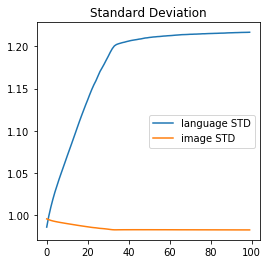

In [56]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

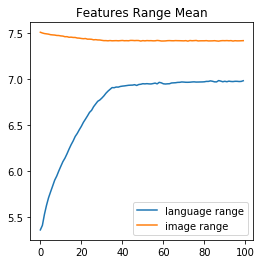

In [20]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

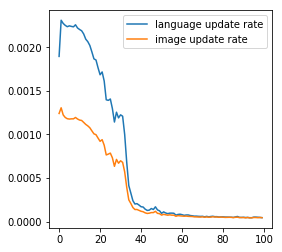

In [68]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
#     P.set_title(title)
    P.plot()
plt.show()

## Conclusion

<p>This Notebook shows the model's sansitivity to the language and image CDS (Cross Domain Statistics). Comparing the cases where we used a BN layer over the language model (with and without a BN layer over the image model) to the model in which we add a BN layer over only the image model, we see that the difference between the statistics has a big impact on both the training behavior and the error surface and that this leads to overfit. Therefore, in order to investigate this, and other problems that combine few models with different statistics, we must first neutralize the CDS effect.</p>